In [2]:
import json
import folium
import datetime
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import IPython
from bs4 import BeautifulSoup
from geopandas.tools import sjoin
from geopy.geocoders import Nominatim
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, plot, iplot
from scipy.stats import pearsonr, spearmanr


%matplotlib inline

## Drawing Maps

The following function draws a map following the provided boundaries. If a dataset is provided, it also shows the dataset value associated with each area in the map. Due to problems with Chrome, we save the map with the chosen filename, instead of visualizing it on the notebook

In [ ]:
def generate_map(geo_json, location, z_vals, legend_name):
    return go.Choroplethmapbox(geojson = geo_json,
                                locations = location,
                                z = z_vals,
                                autocolorscale = True,
                                visible = False,
                                #text = [legend_name + " : " + str(round(x,2)) for x in z_vals],
                                #hoverinfo = 'location<br>text',
                                hovertemplate = "%{location}<br>" + 
                                                legend_name + " : %{z:,.2f}",     
                                name = '',
                                marker_opacity=0.7, 
                                marker_line_width=0.1)
                                #colorscale="Viridis")

# Set log to True if you want to draw the map in log scale as well
def create_map_traces(geo_json, data, log, legend_name):
    traces = []
    traces.append(generate_map(geo_json, data.index, data.values.ravel(), legend_name))
    if (log):
        traces.append(generate_map(geo_json, data.index, np.log(data.values), 'Log ' + legend_name))
        traces[-1]['visible'] = True
    else :
        traces[0]['visible'] = True
    return traces

# The number of button labels must be consistent with the number of maps
def create_map_buttons(button_labels):
    buttons = []
    for i in range(len(button_labels)):
        visible_vector = [False] * len(button_labels)
        visible_vector[i] = True
        dict_obj =  dict(label = button_labels[i],
                         method = 'update',
                         args = [{'visible': visible_vector } ,
                             #{'title': 'Yahoo High'},
                            ] )
        buttons.append(dict_obj)
    return buttons


In [ ]:
def plot_map(data=None, legend_name=" ", log=False): 
    # Retrieving the geo_json in json format
    with open('data/chicago_boundaries_community_area.geojson') as f:
        community_areas_geojson = json.load(f)
    community_areas = []
    for i in range(len(community_areas_geojson['features'])):
        community_area = community_areas_geojson['features'][i]['properties']['community']
        community_areas.append(community_area)
        community_areas_geojson['features'][i]['id'] = community_area
    
    # Instanciating the map
    fig = go.Figure()
    
    # Creating traces
    map_traces = create_map_traces(community_areas_geojson, data, log, legend_name)
    
    # Creating buttons
    if (log) :
        dropdown_buttons = create_map_buttons([legend_name,"Log " + legend_name])
    else : 
        dropdown_buttons = create_map_buttons([legend_name])
        
    # Adding traces
    for trace in map_traces:
        fig.add_trace(trace)
        
    # Positioning
    fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=9, mapbox_center = {"lat": 41.8523, "lon": -87.6660})
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    
    # Adding the buttons (no need in displaying them if there is only one map)
    if len(dropdown_buttons)>1 : 
        fig.update_layout(updatemenus=[
            go.layout.Updatemenu(
                 #type="buttons",
                 active = len(dropdown_buttons) - 1,
                 buttons=list(dropdown_buttons),
                 showactive=True,
                 x = 0,
                 y = 1,
                  xanchor = 'left',
                  yanchor = 'top'
                )])
    
    # Plotting
    iplot(fig,
         #config={'scrollZoom': False}
         )

#LAYOUT POUR TOUT LE RESTE ?
# Adapter les map plots avec les vidéos youtube que j'ai vu (changer le display du hover, rajouter titre sur bar..)

## Community Areas

This dataset was provided by the city of Chicago's government. It divides the city into community areas. Throughout our project, we use these community areas as neighborhoods about which we will present and study correlations between food quality and socio-economical variables.

In [ ]:
geo_df = gpd.read_file("data/chicago_boundaries_community_area.geojson")
geo_df.head()

In [ ]:
geo_df = geo_df[["community", "shape_area", "shape_len", "geometry", "area_num_1"]]
len(geo_df)

In [ ]:
geo_df = geo_df.rename(columns={"area_num_1": "community_number"})
geo_df["community_number"] = geo_df["community_number"].astype(int)
geo_df.head()

In [ ]:
com_number = geo_df[['community','community_number']].set_index('community')
plot_map(com_number, legend_name="Community number")

## Assigning Coordinates to Community Area

We define the following functions in order to assign a coordinate (i.e., a food inspection location) to the community area in which it is located. If a point is not inside any community area (e.g., in the boundary), we assign it to the nearest one.

In [ ]:
def get_nearest_neigh(point, geo_df):
    idx = geo_df.geometry.distance(point).idxmin()
    return geo_df.loc[idx, 'community']

## key: key that will be used to join
def assign_community(geo_df, data, latitude="latitude", longitude="longitude", verbose=False):
    geometry = [Point(x, y) for x, y in zip(data[longitude], data[latitude])]
    crs = {'init': 'epsg:4326'}
    data_to_join = gpd.GeoDataFrame(data, 
                                       crs=crs,
                                       geometry=geometry)
    points_to_neigh = sjoin(data_to_join, geo_df, how='left')
    
    neigh_not_found = points_to_neigh[pd.isna(points_to_neigh['community'])]
    
    if verbose:
        print("There are {} points without an exact neighborhood".format(len(neigh_not_found)))
    
    neigh_not_found['community'] = neigh_not_found.copy().geometry.apply(get_nearest_neigh, geo_df=geo_df)
    points_to_neigh.loc[neigh_not_found.index] = neigh_not_found
    
    if verbose:
        print("There are {} points without an exact neighborhood"\
              .format(len(points_to_neigh[pd.isna(points_to_neigh['community'])])))
    
    columns_to_return = list(data.columns) + ["community"]
    return points_to_neigh[columns_to_return]

## Census Data

In order to normalize our results and analyze food quality prejudice by color, we also obtained information of the latest census conducted in Chicago.

In [ ]:
census = pd.read_csv("data/census.csv", header=1)
census.head()

In [ ]:
columns_to_keep = ["Community", "Total Population", "Percent Hispanic", "Percent Non‐ Hispanic Black",
                   "Percent Non‐ Hispanic White", "Percent Non‐ Hispanic Asian",
                   "Percent Non‐ Hispanic Other or Multiple Races"]
census = census[columns_to_keep]
## Renaming
census.columns = ["community", "population", "hispanic", "black", "white", "asian", "other"]
census = census.drop(census.tail(1).index)

In [ ]:
races = ["hispanic", "black", "white", "asian", "other"]
census[races] = census[races].apply(lambda x: x.str.replace("%", "").astype("int32"), axis=0)
census["population"] = census["population"].str.replace(",", "").astype("int32")
census["community"] = census["community"].str.upper()
census.head()

In [ ]:
census.loc[census['community'] == "O'HARE", 'community'] = 'OHARE'

In [ ]:
## Check if the two dataframe indeed have the same community areas
set(geo_df["community"]) == set(census["community"])

## Food Inspections in Chicago

The main dataset in our project contains information about food inspections in the city of Chicago from 2010 to the present. We use the results of food inspections as a proxy of food quality in a certain community.

We drop inspections from our dataset if:
* The inspection does not indicate a pass or a failure, since we cannot evaluate the food quality without this information.
* The inspection does not assign a risk to a inspections/establishment, since we cannot evaluate the food quality without this information.
* The inspection does not have a location (i.e., latitude and longitude) because we cannot assign it to a community.

In [4]:
inspections = pd.read_csv("data/food-inspections.csv")
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,2216009.0,Daycare Above and Under 2 Years,Risk 1 (High),1300 W 99TH ST,CHICAGO,IL,60643.0,...,Pass,NaN,41.714168,-87.655291,"{'longitude': '41.7141680989703', 'latitude': ...",NaN,NaN,NaN,NaN,NaN
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,CHICAGO,IL,60647.0,...,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.913588,-87.682203,"{'longitude': '41.9135877900482', 'latitude': ...",NaN,NaN,NaN,NaN,NaN
2,2320328,LAS ASADAS MEXICAN GRILL,LAS ASADAS MEXICAN GRILL,2583309.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,Out of Business,NaN,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN
3,2320319,LA PALAPITA,LA PALAPITA,2694702.0,Restaurant,Risk 1 (High),3834 W 47TH ST,CHICAGO,IL,60632.0,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.808025,-87.720037,"{'longitude': '41.80802515275297', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2320228,47TH ST CANTINA,47TH ST CANTINA,2678250.0,Liquor,Risk 3 (Low),4311 W 47TH ST,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.807662,-87.731480,"{'longitude': '41.80766199360051', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [5]:
columns_to_keep = ["Inspection ID", "DBA Name", "AKA Name", "Risk", "Results", "Latitude", "Longitude", "Violations", "Inspection Date"]
inspections = inspections[columns_to_keep]
## Renaming
inspections.columns = ["inspection_id", "dba_name", "aka_name", "risk", "results", "latitude", "longitude", "violations", "date"]

In [6]:
## Mapping to redifine the risk

def map_risk(x_):
    x = str(x_)
    if "High" in x:
        return 1
    elif "Medium" in x:
        return 2
    elif "Low" in x:
        return 3
    else:
        return x
    
## Mapping to retrieve the value of the violation
    
def map_n_violations(x_):
    x = str(x_)
    if x == 'nan':
        return 0
    return len(x.split("|"))
    
## Reformating the dataframe
inspections["date"] = pd.to_datetime(inspections["date"])
inspections = inspections.dropna(subset=["latitude", "longitude"])
inspections = inspections[inspections["results"].isin(["Pass", "Pass w/ Conditions", "Fail"])]
inspections["risk"] = inspections["risk"].apply(map_risk)
inspections = inspections[inspections["risk"].isin([1, 2, 3])]
inspections["risk"] = inspections["risk"].astype("int16")
inspections["n_violations"] = inspections["violations"].apply(map_n_violations)
inspections["n_violations"] = inspections["n_violations"].astype("int32")
inspections.head()

,inspection_id,dba_name,aka_name,risk,results,latitude,longitude,violations,date,n_violations
0,2320315,SERENDIPITY CHILDCARE,SERENDIPITY CHILDCARE,1,Pass,41.714168,-87.655291,NaN,2019-10-23,0
1,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,1,Pass w/ Conditions,41.913588,-87.682203,23. PROPER DATE MARKING AND DISPOSITION - Comm...,2019-10-23,4
3,2320319,LA PALAPITA,LA PALAPITA,1,Pass,41.808025,-87.720037,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,2019-10-23,1
4,2320228,47TH ST CANTINA,47TH ST CANTINA,3,Pass w/ Conditions,41.807662,-87.731480,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",2019-10-22,3
5,2320261,CRAZY BIRD,CRAZY BIRD,1,Pass w/ Conditions,41.891193,-87.657055,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,2019-10-22,4


In [ ]:
## Assigning the community areas
inspections_community = assign_community(geo_df, inspections, verbose=True)
inspections_community.head()

The following maps show:
1. The log-number of inspections in each community per 100 citizens.
2. Rate of inspection failure by community.
3. A community's average risk of an establishment adversely affecting the public’s health in the range [0, 3], with three indicating a higher risk.
4. The average number of food inspection violations in each community per 10000 citizens.
5. The number of inspections in each community normalized by number of establishments in our dataset.
6. The number of violations in each community normalized by number of establishments in our dataset.

In [ ]:
population_community = census[["community", "population"]].set_index("community")["population"]
n_establishments = inspections_community.groupby("community")["dba_name"].nunique()

In [ ]:
## 1) Number of inspections per capita
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
n_inspections_per_capita = n_inspections.div(population_community)
plot_map(data=n_inspections_per_capita, legend_name="Number of inspections per capita", log=True)

In [ ]:
## 2) Rate of failure
neigh_results = inspections_community.groupby(["community", "results"]).count()["inspection_id"].rename("values")
percentage_results = (neigh_results.div(n_inspections) * 100).reset_index()
failure_community = percentage_results[percentage_results["results"]=="Fail"]
failure_community = failure_community.drop("results", axis="columns").set_index("community")["values"]
plot_map(data=failure_community, legend_name='Rate of failure (%)')

In [ ]:
## 3) Average risk
average_risk = inspections_community.groupby("community").mean()["risk"].rename("values")
plot_map(data=average_risk, legend_name='Average risk (between 1 and 3)')

In [ ]:
## 4) Number of violations per capita
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
average_violations_per_capita = average_violations.div(population_community)
plot_map(data=average_violations_per_capita, legend_name='Average number of food violations per capita', log=True)

In [ ]:
## 5) Number of inspections / # establishments
n_inspections = inspections_community.groupby("community").count()["inspection_id"].rename("values")
norm_n_inspections = n_inspections.div(n_establishments)
plot_map(data=norm_n_inspections, legend_name='Normalized Number of inspections per establishment')

In [ ]:
## 6) Number of violations / # establishments
average_violations = inspections_community.groupby("community").mean()["n_violations"].rename("values")
norm_average_violations = average_violations.div(n_establishments)
plot_map(data=norm_average_violations, legend_name='Normalized Number of food violations per establishment', log=True)

We can see through these maps that the food is indeed not of the same quality across all community areas.

## Hardship Index

The city of Chicago also makes available the economic hardship of all its community areas. The economic hardship index is a function of:

1. Unemployment (over the age of 16 years),
2. Education (over 25 years of age without a high school
diploma)
3. Per capita income level
4. Poverty (below the federal poverty level)
5. Crowded housing (housing units with more than one person
per room)
6. Dependency (population under 18 or over 64 years of age)

We will use the economic hardship index as a measurement of economic conditions of each community area in Chicago. A higher index indicates poorer conditions. For more information on the index: https://greatcities.uic.edu/wp-content/uploads/2016/07/GCI-Hardship-Index-Fact-SheetV2.pdf

In [ ]:
income_df = pd.read_csv("data/Per_Capita_Income.csv")
income_df.head()

In [ ]:
## Renaming
income_df.columns = ['community_number','community','percentage_housing_crowded','percent_households_below_poverty','percent_aged_16+_unemployed','percent_aged_25+_without_highschool_diploma','percent_aged_under_18_or_over_64','per_capita_income','hardship_index']
income_df["community"].unique

In [ ]:
## Getting rid of the non relevant last row
income_df = income_df[income_df["community"] != 'CHICAGO']
## Reformating the community area names
income_df["community"] = income_df["community"].str.upper()

In [ ]:
## Checking if the income dataframe has the same community areas as the geojson dataframe
set(geo_df["community"]) == set(income_df["community"])

In [ ]:
## Displaying the differences
set(geo_df["community"]) - set(income_df["community"])

In [ ]:
set(income_df["community"]) - set(geo_df["community"])

In [ ]:
## Correcting the issue 
income_df.loc[income_df['community'] == "O'HARE", 'community'] = 'OHARE'
income_df.loc[income_df['community'] == "MONTCLAIRE", 'community'] = 'MONTCLARE'
income_df.loc[income_df['community'] == "WASHINGTON HEIGHT", 'community'] = 'WASHINGTON HEIGHTS'
## Checking if the income dataframe has the same community areas
set(geo_df["community"]) == set(income_df["community"])

We normalize hardship into a [0, 1] range for our analysis. Since hardship is not a concept easy to understand as it is a function of many economic variables, we believe that comparing between communities will be easier after normalizing the index.

In [ ]:
delta_hardship = income_df["hardship_index"].max() - income_df["hardship_index"].min()
income_df["hardship_index"] = (income_df["hardship_index"] - income_df["hardship_index"].min())/delta_hardship

In [ ]:
hardship = income_df[["community", "hardship_index"]].set_index("community").rename(columns={"hardship_index": "values"})["values"]
plot_map(data=hardship, legend_name='Hardship Index')

### 1) Correlation Between Race and Food Quality

Since each community areas has a dominant race, and that food quality varies from one community to another, we speculate that the food quality may vary depending on the race.

In [ ]:
def plot_correlation_food_variables(food_quality_index=None, index_name="",
                                    variables_df=None, variables=None, variable_name="", method="pearson"):
    correlations = []
    for var in variables:
        var_community = variables_df[["community", var]].set_index("community")[var]
        correlations.append(var_community.corr(food_quality_index, method=method))
    plt.bar(x=variables, height=correlations)
    plt.title("Correlation between {} and {}".format(variable_name, index_name))

In [ ]:
def scatter_plot(food_quality_index=None, index_name="",
                           variable_df=None, variable_name="", method="pearson"):
    plt.ylabel(index_name)
    plt.xlabel(variable_name)
    plt.scatter(variable_df, food_quality_index)

In [ ]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
plot_correlation_food_variables(n_inspections_per_capita, index_name="number of inspections per capita",
                                variables_df=census, variables=races, variable_name="race")

## 2) Rate of failure
plt.subplot(3, 2, 2)
plot_correlation_food_variables(failure_community, index_name="failure rate",
                                variables_df=census, variables=races, variable_name="race")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
plot_correlation_food_variables(average_risk, index_name="average risk",
                                variables_df=census, variables=races, variable_name="race")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
plot_correlation_food_variables(average_violations_per_capita, index_name="inspection violations per capita",
                                variables_df=census, variables=races, variable_name="race")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
plot_correlation_food_variables(norm_n_inspections, index_name="normalized number of inspections",
                                variables_df=census, variables=races, variable_name="race")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
plot_correlation_food_variables(norm_average_violations, index_name="normalized inspection violations",
                                variables_df=census, variables=races, variable_name="race")

Apparently, the black population lives in community areas with lower quality of food, a higher number of inspection violations, a lower number of inspections as well as a higher risk.

On the other hand, it is the complete opposite for the white population: they have higher quality of food, a lower number of inspection violations, a higher number of inspections and a lower value of risk.

In [ ]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita

plt.subplot(3, 2, 1)
scatter_plot(n_inspections_per_capita, index_name="number of inspections per capita",
                                variable_df=census["black"], variable_name="percentage of black population")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot(failure_community, index_name="failure rate",
                                variable_df=census["black"], variable_name="percentage of black population")

## 3) Average risk
## I'm pretty sure that the mapping function of risk is the opposite of what we are doing right now
plt.subplot(3, 2, 3)
scatter_plot(average_risk, index_name="average risk",
                                variable_df=census["black"], variable_name="percentage of black population")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot(average_violations_per_capita, index_name="inspection violations per capita",
                                variable_df=census["black"], variable_name="percentage of black population")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=census["black"], variable_name="percentage of black population")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=census["black"], variable_name="percentage of black population")

In [ ]:
# If we use this function, we shouldn't use the buttons
def add_plot_trace_with_legend_without_corr(traces, food_quality_index=None, index_name="",
                           variable_df=None, variable_name="",):
    traces.append(go.Scatter(x=variable_df, 
                             y=food_quality_index,
                             mode='markers',
                             #text = [index_name + " : \n" + str(round(y,3)) for y in food_quality_index],
                             #hoverinfo = 'text',
                             hovertemplate = index_name + " : %{y:,.3f}<br>" + 
                                             variable_name + " : %{x}%",
                             name=index_name,
                             showlegend = True,
                             marker_color=food_quality_index))
    traces[-1]['visible'] = 'legendonly'
    return traces

def add_plot_trace_without_corr(traces, food_quality_index=None, index_name="",
                           variable_df=None, variable_name="",):
    traces.append(go.Scatter(x=variable_df, 
                             y=food_quality_index,
                             mode='markers',
                             #text = [index_name + " : \n" + str(round(y,3)) for y in food_quality_index],
                             #hoverinfo = 'text',
                             hovertemplate = index_name + " : %{y:,.3f}<br>" + 
                                             variable_name + " : %{x}%",
                             name='',
                             marker_color=food_quality_index))
    traces[-1]['visible'] = False
    return traces

In [ ]:
def add_plot_trace(traces, food_quality_index=None, index_name="",
                           variable_df=None, variable_name="",):
    corr_p, pval_p = pearsonr(food_quality_index, variable_df)
    if pval_p<0.05:
        p_sgn = "Significant"
    else :
        p_sgn = "Not Significant"
    corr_s, pval_s = spearmanr(food_quality_index, variable_df)
    if pval_s<0.05:
        s_sgn = "Significant"
    else :
        s_sgn = "Not Significant"
    traces.append(go.Scatter(x=variable_df, 
                             y=food_quality_index,
                             mode='markers',
                             hovertemplate = index_name + " : %{y:,.3f}<br>" + 
                                             variable_name + " : %{x}%",
                             name="<b>Correlations :</b><br>" +
                                 "<i>Pearson's</i> : <br>" + 
                                 "Value : " + str(round(corr_p,2)) + ", P-value : " + str(round(pval_p,2)) + ", <b>" + p_sgn + "</b><br>" +
                                 "<i>Spearman's</i> : <br>" + 
                                 "Value : " + str(round(corr_s,2)) + ", P-value : " + str(round(pval_s,2)) + ", <b>" + s_sgn + "</b><br>",
                             marker_color=food_quality_index))
    traces[-1]['visible'] = False
    return traces

In [ ]:
def create_plot_buttons(button_labels):
    buttons = []
    #name = ['okok','okok2','okok3','okok4','okok5','okok6']
    for i in range(len(button_labels)):
        visible_vector = [False] * len(button_labels)
        visible_vector[i] = True
        dict_obj =  dict(label = button_labels[i],
                         method = 'update',
                         #name = name[i],
                         args = [{'visible': visible_vector } ,
                         #{'title': 'Yahoo High'},
                            ] )
        buttons.append(dict_obj)
    return buttons  

In [ ]:
# Instanciating the figure
fig = go.Figure()

# Creating traces
scatter_traces = []
## 1) Number of inspections per capita
scatter_traces = add_plot_trace(scatter_traces, n_inspections_per_capita, index_name="Number of inspections per capita",
                            variable_df=census["black"], variable_name="Percentage of black population")
## 2) Rate of failure
scatter_traces = add_plot_trace(scatter_traces, failure_community, index_name="Failure rate (%)",
                            variable_df=census["black"], variable_name="Percentage of black population")
## 3) Average risk
scatter_traces = add_plot_trace(scatter_traces, average_risk, index_name="Average risk (1-3)",
                            variable_df=census["black"], variable_name="Percentage of black population")
## 4) Number of violations per capita
scatter_traces = add_plot_trace(scatter_traces, average_violations_per_capita, index_name="Inspection violations per capita",
                            variable_df=census["black"], variable_name="Percentage of black population")
## 5) # inspections / # establishments
scatter_traces = add_plot_trace(scatter_traces, norm_n_inspections, index_name="Normalized number of inspections",
                            variable_df=census["black"], variable_name="Percentage of black population")
## 6) # violations / # establishments
scatter_traces = add_plot_trace(scatter_traces, norm_average_violations, index_name="Normalized inspection violations",
                            variable_df=census["black"], variable_name="Percentage of black population")

scatter_plot_titles = ['Number of inspections per capita',# / Percentage of black population',
                       'Failure rate (%)',# / Percentage of black population',
                       'Average risk (1-3)',# / Percentage of black population',
                       'Inspection violations per capita',# / Percentage of black population',
                       'Normalized number of inspections',# / Percentage of black population',
                       'Normalized inspection violations']# / Percentage of black population']

# Rendering the last scatter plot visible
scatter_traces[-1]['visible'] = True

# Creating buttons
dropdown_buttons = create_plot_buttons(scatter_plot_titles)

# Adding traces
for trace in scatter_traces:
    fig.add_trace(trace)

# Adding the buttons 
fig.update_layout(
    xaxis = dict(title = "Percentage of black population"),
    title = dict(text = "<b>Food quality index / Percentage of black population</b>", x=0.5),
    updatemenus=[
    go.layout.Updatemenu(
         active = len(dropdown_buttons) - 1,
         buttons = list(dropdown_buttons),
         showactive=True,
         x = 0,
         y = 1.1,#Change to 1 if you want to display it on the top left corner inside the plot
          xanchor = 'left',
          yanchor = 'top'
        )])

# Plotting
iplot(fig)

#Rajouter un titre

Unfortunately the scatterplots don't show any correlation. We'll then proceed with a significance test of our correlation index. Note that some of them have a range that is hard to work with. We will then conduct both a pearson and spearman correlation tests to check whether they are correlated.

In [ ]:
def correlation_and_pvalue(x_dict,y):
    for x in x_dict:
        corr_p, pval_p = pearsonr(x["data"], y)
        corr_s, pval_s = spearmanr(x["data"], y)
        print(x["name"])
        print("Pearson   r={}, p-value={}\t{}".format(corr_p, pval_p, "Significant" if pval_p < 0.05 else "Not significant"))
        print("Spearman  r={}, p-value={}\t{}\n".format(corr_s, pval_s, "Significant" if pval_s< 0.05 else "Not significant"))
        
variables_list = [
    {"name": "N Inspection Per Capita", "data": n_inspections_per_capita},
    {"name": "Failure Rate", "data": failure_community},
    {"name": "Average Risk", "data": average_risk},
    {"name": "N Violations Per Capita", "data": average_violations_per_capita},
    {"name": "N Inspection Per Establishment", "data": norm_n_inspections},
    {"name": "N Violations Per Establishment", "data": norm_average_violations}
]

In [ ]:
correlation_and_pvalue(variables_list, census["black"])

In [ ]:
correlation_and_pvalue(variables_list, census["white"])

There is a significant correlation between number of inspections between race composition of a community and number of inspections. The relation, however, does not seem to be linear. 
- The more black people there is in a community, the higher the number of inspections per capita in that community. The opposite trend is found for white people.

### 2) Correlation Between Hardship and Food Quality

The higher the hardship index is, the lower are the educational and income level.
We then speculate that the higher the educational and income level, the higher is the food quality.

In [ ]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
scatter_plot(n_inspections_per_capita, index_name="number of inspections per capita",
                                variable_df=hardship, variable_name="hardship")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot(failure_community, index_name="failure rate",
                                variable_df=hardship, variable_name="hardship")

## 3) Average risk
plt.subplot(3, 2, 3)
scatter_plot(average_risk, index_name="average risk",
                                variable_df=hardship, variable_name="hardship")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot(average_violations_per_capita, index_name="inspection violations per capita",
                                variable_df=hardship, variable_name="hardship")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=hardship, variable_name="hardship")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=hardship, variable_name="hardship")

Unfortunately, these scatter plots seem to prove the initial assumption wrong: there doesn't seem to be any correlation between the hardship and the food quality.

In [ ]:
correlation_and_pvalue(variables_list, hardship)

No correlation is significant according to the p-values obtained.

# Crime Dataset Investigation

In [16]:
crime_df = pd.read_csv('data/Crimes_2001-2019.csv')
crime_df.head()

C:\Users\nikom\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.



,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,8.0,45.0,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


Limit the data to the period 2010-2019

In [17]:
crime_df = crime_df.loc[crime_df.Year>2009]
crime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [ ]:
crime_df['Primary Type'].unique()

Some types of violation can be excluded for some resons:
- Liquor law violation is not an index of a dangerous neighborhood
- Non-criminal actions are used to code police calls that are not crimes
- Concealed carry license violations are assigned to a vehicle in movement so we can not connect the place where is found to its original neighborhood

In [18]:
crime_df = crime_df[~crime_df['Primary Type'].isin(['LIQUOR LAW VIOLATION','CONCEALED CARRY LICENSE VIOLATION','NON-CRIMINAL','NON - CRIMINAL','NON-CRIMINAL (SUBJECT SPECIFIED)'])]
crime_df.head(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,21.0,73.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,False,False,...,18.0,70.0,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,20.0,42.0,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
5,11227517,JB138481,02/10/2013 12:00:00 AM,071XX S LAFAYETTE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,6.0,69.0,02,NaN,NaN,2013,02/11/2018 03:57:41 PM,NaN,NaN,NaN
6,11227503,JB146383,01/01/2015 12:01:00 AM,061XX S KILBOURN AVE,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,...,13.0,65.0,17,NaN,NaN,2015,04/12/2019 04:00:15 PM,NaN,NaN,NaN
7,11227508,JB146365,01/01/2017 12:01:00 AM,027XX S WHIPPLE ST,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,False,...,12.0,30.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
8,11022695,JA353568,07/17/2017 10:10:00 AM,021XX W MC LEAN AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,...,32.0,22.0,06,NaN,NaN,2017,07/24/2017 03:54:23 PM,NaN,NaN,NaN
9,11227633,JB147500,12/28/2017 03:55:00 PM,011XX S MICHIGAN AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,2.0,32.0,11,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
10,11227586,JB147613,02/10/2017 12:00:00 PM,089XX S COTTAGE GROVE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,8.0,44.0,14,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [ ]:
crime_df.columns

In [ ]:
crime_df['Location']

Note that community area 0 is not a real community area. It is an outlier which (we hypothesize) indicates crimes in areas around Chicago. Also, there is no community area with number 0 in the GeoJson file provided by the city of Chicago.

We will finally assign the community area where the crime was commited by comparing the *community_number* column of the GeoJson.

In [ ]:
crime_df["Community Area"].value_counts()

In [ ]:
crime_df.drop(['ID', 'Case Number', 'Domestic', 'Beat', 'Ward', 'FBI Code', 'Updated On', 'Block', 'Description', 'Location Description', 'Arrest', 'IUCR', 'Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
crime_df = crime_df[crime_df["Community Area"] != 0.0]

In [ ]:
crime_df.head()

In [ ]:
crimes_by_community = crime_df.groupby('Community Area').count()['Date'].rename('values')
crimes_by_community.index = geo_df.sort_values("community_number")["community"]
crimes_by_community

In [ ]:
criminality = crimes_by_community.div(population_community)
criminality

In [ ]:
plot_map(data=criminality, legend_name="Crimes per capita")

The map shows 2 areas composed by more communities that have more criminality, there is some overlapping between these areas and the parts where there are more food violations

In [ ]:
correlation_and_pvalue(variables_list, criminality)

Our results show that there is no significant correlation between criminality and food quality. We also plot the scatter plots for visualization.

In [ ]:
plt.figure(figsize=(15, 13))

## 1) Number of inspections per capita
plt.subplot(3, 2, 1)
scatter_plot(n_inspections_per_capita, index_name="number of inspections per capita",
                                variable_df=criminality, variable_name="crimes per capita")

## 2) Rate of failure
plt.subplot(3, 2, 2)
scatter_plot(failure_community, index_name="failure rate",
                                variable_df=criminality, variable_name="crimes per capita")

## 3) Average risk
plt.subplot(3, 2, 3)
scatter_plot(average_risk, index_name="average risk",
                                variable_df=criminality, variable_name="crimes per capita")

## 4) Number of violations per capita
plt.subplot(3, 2, 4)
scatter_plot(average_violations_per_capita, index_name="inspection violations per capita",
                                variable_df=criminality, variable_name="crimes per capita")

## 5) # inspections / # establishments
plt.subplot(3, 2, 5)
scatter_plot(norm_n_inspections, index_name="normalized number of inspections",
                                variable_df=criminality, variable_name="crimes per capita")

## 6) # violations / # establishments
plt.subplot(3, 2, 6)
scatter_plot(norm_average_violations, index_name="normalized inspection violations",
                                variable_df=criminality, variable_name="crimes per capita")

## Time correlation between food inspection and crimes

In [14]:
inspections['year'] = inspections['date'].dt.year
df_inspections_per_year = inspections.groupby(['year']).count()
df_inspections_per_year.head(10)

,inspection_id,dba_name,aka_name,risk,results,latitude,longitude,violations,date,n_violations
year,,,,,,,,,,
2010,17301,17301,16963,17301,17301,17301,17301,12418,17301,17301
2011,17507,17507,17222,17507,17507,17507,17507,13428,17507,17507
2012,15943,15943,15678,15943,15943,15943,15943,13258,15943,15943
2013,17020,17020,16745,17020,17020,17020,17020,14685,17020,17020
2014,18561,18561,18375,18561,18561,18561,18561,16238,18561,18561
2015,17833,17833,17662,17833,17833,17833,17833,15574,17833,17833
2016,19789,19789,19705,19789,19789,19789,19789,17136,19789,19789
2017,18416,18416,18355,18416,18416,18416,18416,15717,18416,18416
2018,14774,14774,14746,14774,14774,14774,14774,12938,14774,14774


In [19]:
df_crime_per_year = crime_df.groupby(['Year']).count()
df_crime_per_year.head(10)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Updated On,Latitude,Longitude,Location
Year,,,,,,,,,,,,,,,,,,,,,
2010,369619,369618,369619,369619,369619,369619,369619,369573,369619,369619,...,369619,369601,369433,369619,369260,369260,369619,369260,369260,369260
2011,351203,351203,351203,351203,351203,351203,351203,350925,351203,351203,...,351203,351189,351022,351203,350684,350684,351203,350684,350684,350684
2012,335476,335475,335476,335476,335476,335476,335476,335058,335476,335476,...,335476,335469,335450,335476,334859,334859,335476,334859,334859,334859
2013,306712,306712,306712,306712,306712,306712,306712,306558,306712,306712,...,306712,306709,306708,306712,305882,305882,306712,305882,305882,305882
2014,274964,274964,274964,274964,274964,274964,274964,274665,274964,274964,...,274964,274962,274964,274964,273278,273278,274964,273278,273278,273278
2015,263900,263900,263900,263900,263900,263900,263900,263440,263900,263900,...,263900,263898,263900,263900,257536,257536,263900,257536,257536,257536
2016,268901,268901,268901,268901,268901,268901,268901,267752,268901,268901,...,268901,268901,268901,268901,266907,266907,268901,266907,266907,266907
2017,268098,268098,268098,268098,268098,268098,268098,266944,268098,268098,...,268097,268097,268098,268098,264624,264624,268098,264624,264624,264624
2018,267125,267125,267125,267125,267125,267125,267125,266211,267125,267125,...,267125,267121,267123,267125,262974,262974,267125,262974,262974,262974


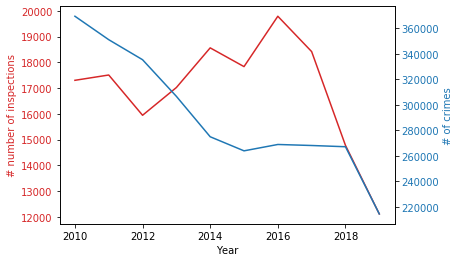

In [21]:
#plt.plot(df_inspections_per_year.index, df_inspections_per_year['n_violations'])
#plt.plot(df_inspections_per_year.index, df_crime_per_year['Primary Type'])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('# number of inspections', color=color)
ax1.plot(df_inspections_per_year.index, df_inspections_per_year['n_violations'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# of crimes', color=color)  # we already handled the x-label with ax1
ax2.plot(df_inspections_per_year.index, df_crime_per_year['Primary Type'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [22]:
corr_lin, p_lin = pearsonr(df_inspections_per_year['n_violations'],df_crime_per_year['Primary Type'])
corr, p = spearmanr(df_inspections_per_year['n_violations'],df_crime_per_year['Primary Type'])

In [23]:
print('Pearson corr:', corr_lin, ' p-val:',p_lin)
print('Spearman corr', corr, 'p-val',p)

Pearson corr: 0.31314067513348753  p-val: 0.37831385318298816
Spearman corr 0.12727272727272726 p-val 0.7260570147627894
